In [400]:
import numpy as np
import matplotlib.pyplot as plt

Let's define some parameters as follows: <br> <br>
$n_{L2}$, $n_{L4}$, $n_{L5}$, $n_{E}$, $n_{M}$: max number of satellites at L2, L4, L5, Earth and the Moon to be used<br>
$loc_{L2}$, $loc_{L4}$, $loc_{L5}$, $loc_E$, $loc_M$: coordinates of each of L2, L4, L5,Earth and Moon <br>
$noise$: amount of difference between satellite locations at each of L2, L4, L5, and Earth (we cannot simply approximate to 4 points as it would cause a singular matrix error) <br><br>
We will also have $x$ as the input (3D list of coords) to represent where a ship is in cislunar space

In [401]:
d_moon = 384000

params = {
    'n_L2': 2,
    'n_L4': 4,
    'n_L5': 4,
    'n_E': 24,
    'n_M': 12,
    'loc_L2': np.array([1.5*d_moon,0,0]),
    'loc_L4': np.array([0.5*d_moon,0.866*d_moon,0]),
    'loc_L5': np.array([0.5*d_moon,-0.866*d_moon,0]),
    'loc_E': np.array([0,0,0]),
    'loc_M': np.array([d_moon, 0, 0]),
    'noise': 100,
}

The Satellites class supports the initialization method using parameters as described above. This will also generate a list of all coordinates for every possible satellite.

In [402]:
class Satellites:


    def __init__(self, params):
        self.L2 = [params['loc_L2'] + params['noise']*(2*np.random.rand(3)-1) for _ in range(params['n_L2'])]
        self.L4 = [params['loc_L4'] + params['noise']*(2*np.random.rand(3)-1) for _ in range(params['n_L4'])]
        self.L5 = [params['loc_L5'] + params['noise']*(2*np.random.rand(3)-1) for _ in range(params['n_L5'])]
        self.E = [params['loc_E'] + params['noise']*(2*np.random.rand(3)-1) for _ in range(params['n_E'])]
        self.M = [params['loc_M'] + params['noise']*(2*np.random.rand(3)-1) for _ in range(params['n_M'])]
        self.locations = [self.L2, self.L4, self.L5, self.E, self.M]
        self.noise = params['noise']

In [403]:
network = Satellites(params)

In [404]:
def generate_G(pos, network):
    # take position and subtract it from all other vectors (X_other - X_pos, Y_other - Y_pos, Z_other - Z_pos)
    # then, normalize that vector
    # repeat for all satellites
    # that's our G :)
    G = []
    for location in network.locations:
        for satellite in location:
            v = satellite - pos
            v = v / np.linalg.norm(v)
            v = np.append(v, 1)
            G.append(v)
    return G

In [405]:
generate_G(np.array([-2,2,-2]), network)

[array([ 9.99999987e-01, -8.46397805e-05,  1.38209840e-04,  1.00000000e+00]),
 array([ 9.99999994e-01, -1.00204715e-04,  4.19045642e-05,  1.00000000e+00]),
 array([ 4.99911005e-01,  8.66076766e-01, -1.49938521e-04,  1.00000000e+00]),
 array([ 5.00010945e-01,  8.66019080e-01, -8.83937043e-05,  1.00000000e+00]),
 array([4.99954079e-01, 8.66051909e-01, 9.99794526e-05, 1.00000000e+00]),
 array([5.00017456e-01, 8.66015299e-01, 2.13489590e-04, 1.00000000e+00]),
 array([ 5.00124499e-01, -8.65953506e-01,  1.03329775e-04,  1.00000000e+00]),
 array([ 4.99903983e-01, -8.66080832e-01, -7.19604027e-06,  1.00000000e+00]),
 array([ 5.00161515e-01, -8.65932121e-01,  1.42966359e-04,  1.00000000e+00]),
 array([ 5.00138806e-01, -8.65945245e-01,  9.10717405e-05,  1.00000000e+00]),
 array([-0.76583303, -0.33207027,  0.55066242,  1.        ]),
 array([-0.82065375,  0.23001773, -0.52308629,  1.        ]),
 array([0.22795331, 0.68516119, 0.69180303, 1.        ]),
 array([ 0.76685789, -0.3783546 ,  0.51843686,

In [406]:
def find_GDOP(pos, network):
    G = generate_G(pos, network)
    Q = np.linalg.inv(np.dot(np.transpose(G), G))
    return np.sqrt(np.trace(Q))

Now to generate GDOP for many locations within cislunar space and plot it, so that we can visualize how GDOP changes in cislunar space.

In [410]:
def generate_GDOP_heatmap(density, x_bounds, y_bounds, z):
    n = density # density of sample points, for computational cost
    x_lower = x_bounds[0]
    x_upper = x_bounds[1]
    y_lower = y_bounds[0]
    y_upper = y_bounds[1]


    X_range = np.linspace(x_lower,x_upper, round((x_upper - x_lower)*n)) # n per lunar distance
    Y_range = np.linspace(y_lower,y_upper, round((y_upper - y_lower)*n)) # n per lunar distance

    X, Y = np.meshgrid(X_range, Y_range)
    C = []
    for y in Y_range:
        cur_row = []
        for x in X_range:
            cur_row.append(find_GDOP(np.array([d_moon*x,d_moon*y,z]), network))
        C.append(cur_row)
    
    return X, Y, np.array(C)

In [419]:
def plot_GDOP_heatmap(density, x_bounds, y_bounds, z):
    X, Y, C = generate_GDOP_heatmap(density, x_bounds, y_bounds, z)

    plt.pcolormesh(X, Y, C, cmap = 'RdBu')
    plt.xlabel("X (LD)")
    plt.ylabel("Y (LD)")
    plt.title("GDOP Heatmap at " + str(z) + " km above Earth-Moon plane")
    plt.plot(0, 0, marker = "o", markersize=14, markeredgecolor="black", markerfacecolor = "green", linewidth=0, label = "Earth")
    plt.plot(1, 0, marker = "o", markersize=7, markeredgecolor="black", markerfacecolor = "gray", linewidth=0, label = "Moon")
    plt.plot(1.5, 0, marker = "o", markersize=8, markeredgecolor="black", markerfacecolor = "white", linewidth=0, label = "L2")
    plt.plot(0.5, 0.866, marker = "o", markersize=8, markeredgecolor="black", markerfacecolor = "white", linewidth=0, label = "L4")
    plt.plot(0.5, -0.866, marker = "o", markersize=8, markeredgecolor="black", markerfacecolor = "white", linewidth=0, label = "L5")
    plt.legend()
    plt.colorbar()
    plt.show()

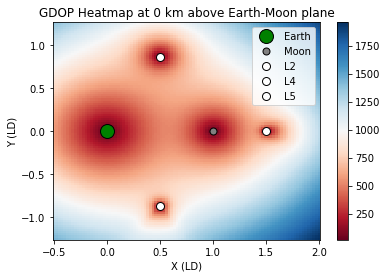

In [422]:
plot_GDOP_heatmap(40, [-0.5, 2], [-1.25, 1.25], 0)

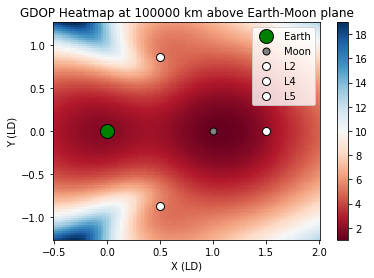

In [423]:
plot_GDOP_heatmap(40, [-0.5, 2], [-1.25, 1.25], 100000)

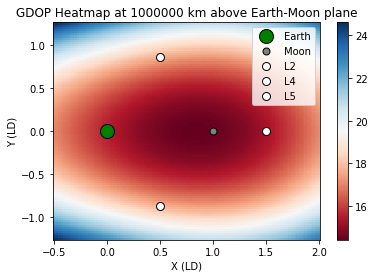

In [426]:
plot_GDOP_heatmap(40, [-0.5, 2], [-1.25, 1.25], 1000000)

https://www.afrl.af.mil/Portals/90/Documents/RV/A%20Primer%20on%20Cislunar%20Space_Dist%20A_PA2021-1271.pdf?ver=vs6e0sE4PuJ51QC-15DEfg%3D%3D